In [1]:
# !pip install gsw

In [2]:
import xesmf as xe
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as cm
from netCDF4 import Dataset
import urllib.request
import gsw

In [3]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
from dask.distributed import Client

cluster = SLURMCluster(
    cores=4,
    memory='15GB',
    walltime='01:00:00',
    queue='compute',
    interface='ib0')
cluster.scale(jobs=1)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.185:43235,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Read in GLORYS Data

In [4]:
data_path = "/vortexfs1/share/cmip6/data/ocean_reanalysis/glorys12v1/1993/"

def preprocess(ds): 
    #select SST and SSS
    ds = ds[["thetao", "so"]].isel(depth = 0)

    #select California Current
    ds = ds.sel(longitude = slice(-125, -110), latitude = slice(25, 45))
    return ds
    
ds = xr.open_mfdataset(data_path + "*.nc", engine = "netcdf4", 
                       parallel = True, preprocess = preprocess)
ds

<xarray.Dataset> Size: 255MB
Dimensions:    (time: 365, latitude: 241, longitude: 181)
Coordinates:
  * longitude  (longitude) float32 724B -125.0 -124.9 -124.8 ... -110.1 -110.0
  * latitude   (latitude) float32 964B 25.0 25.08 25.17 ... 44.83 44.92 45.0
    depth      float32 4B 0.494
  * time       (time) datetime64[ns] 3kB 1993-01-01T12:00:00 ... 1993-12-31T1...
Data variables:
    thetao     (time, latitude, longitude) float64 127MB dask.array<chunksize=(1, 104, 60), meta=np.ndarray>
    so         (time, latitude, longitude) float64 127MB dask.array<chunksize=(1, 104, 60), meta=np.ndarray>
Attributes: (12/24)
    title:              daily mean fields from Global Ocean Physics Analysis ...
    easting:            longitude
    northing:           latitude
    history:            2017/04/06 14:05:19 MERCATOR OCEAN Netcdf creation
    source:             MERCATOR GLORYS12V1
    institution:        MERCATOR OCEAN
    ...                 ...
    longitude_min:      -180.0
    longitude_max:      179.91667
    latitude_min:       -80.0
    latitude_max:       90.0
    z_min:              0.494025
    z_max:              5727.917

### GSW Toolbox and Dask

Using GSW functions in dask requires a bit more thought if you want to run things in parallel. In order to use these functions and execute them in parallel AND avoid loading everything into memory, you must use ``xr.apply_ufunc``. Let's use ``xr.apply_ufunc`` to compute ``sigma0`` (i.e. potential density referenced to 0 dbar).

In [5]:
#compute pressure 
ds['p'] = xr.apply_ufunc(
    gsw.p_from_z, ds.depth, ds.latitude, 0, 0, dask="parallelized"
)

# compute absolute salinty 
ds['sa'] = xr.apply_ufunc(
    gsw.SA_from_SP,
    ds.so,
    ds.p,
    ds.longitude,
    ds.latitude,
    dask="parallelized",
)

# compute conservative temperature 
ds['ct'] = xr.apply_ufunc(
    gsw.CT_from_t,
    ds.sa,
    ds.thetao,
    ds.p,
    dask="parallelized"
)

#finally, compute sigma0
ds['sigma0'] = xr.apply_ufunc(
    gsw.sigma0,
    ds.sa,
    ds.ct,
    dask="parallelized"
)

In [6]:
data = ds['sigma0'].mean("time").compute()

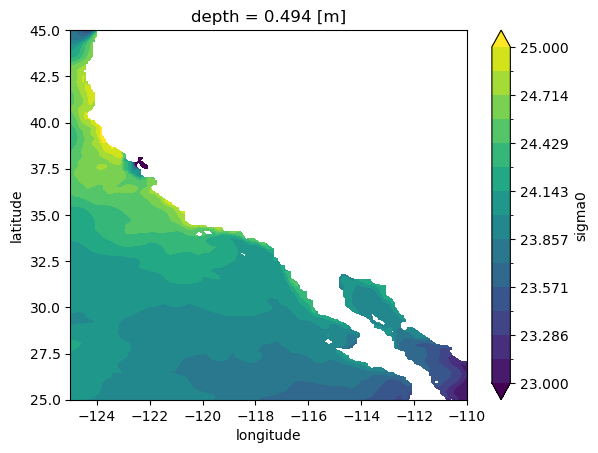

In [7]:
data.plot.contourf(vmin = 23, vmax = 25, levels = 15)